START: OWN CODE  (This file is all self-written)

In [8]:
import cv2
import numpy as np
from tqdm import tqdm
import os

In [9]:
def MyPCA(data,n):
    mean=np.mean(data,axis=0)
    data_new=data-mean
    Cov=data_new.T.dot(data_new)
    lamb,v=np.linalg.eig(Cov)
    index=np.argsort(lamb)[::-1]
    A=-v[:,index]
    w=data_new.dot(A)
    # r=lamb[index]/lamb.sum()
    return w[:,:n]

In [10]:
from sklearn.preprocessing import StandardScaler
def get_feature(filepath):
    cate=[filepath+'/'+x for x in os.listdir(filepath) if os.path.isdir(filepath+'/'+x)]
    features = np.float32([]).reshape(0, 128)
    label=[]
    for idx,folder in tqdm(enumerate(cate)):
        for im in glob.glob(folder+'/*.jpg'):
            # print(im)
            img=cv2.imread(im)
            # gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            sift=cv2.SIFT_create()
            key, feature=sift.detectAndCompute(img,None)
            feature = StandardScaler().fit_transform(feature)
            features = np.append(features, feature, axis=0)
            label.append(idx)
    return features,label

In [11]:
def compute_data_vec(centers,path,wordCnt):
    label=[]
    data_vec = np.float32([]).reshape(0, int(wordCnt))
    cate=[path+'/'+x for x in os.listdir(path) if os.path.isdir(path+'/'+x)]
    for idx,folder in tqdm(enumerate(cate)):
        for im in glob.glob(folder+'/*.jpg'):
            # print(idx)
            img=cv2.imread(im)
            # gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            sift=cv2.SIFT_create()
            key, feature=sift.detectAndCompute(img,None)
            featVec = np.zeros((1, int(wordCnt)))
            for i in range(0, feature.shape[0]):
                distance = ((np.tile(feature[i], (int(wordCnt), 1)) - centers)**2).sum(axis=1)
                distance = distance**0.5
                increase_index = distance.argsort()
                index = increase_index[0]
                featVec[0][index] += 1
            data_vec = np.append(data_vec,featVec,axis=0)
            label.append(idx)
    return data_vec,label

In [12]:
image_path = './archive/image'

In [13]:
features,labels = get_feature(image_path)
print("get features")

6it [1:16:14, 762.44s/it]

get features


In [14]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.1)
random_center = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(features, 100, None,criteria, 20, random_center)
filename = "./centers_100.npy"
np.save(filename, centers)

In [15]:
centers = np.load("./centers_100.npy")

In [16]:
data_vec,labels=compute_data_vec(centers,image_path,100)


6it [04:01, 40.27s/it]


In [20]:
print(data_vec.shape)

(17013, 100)


In [21]:
print(features.shape)
# print(labels.shape)
labels=np.array(labels)
print(labels.shape)

(2621424, 128)
(17013,)


In [35]:
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn import model_selection

feature_scale = np.arange(10,100,10)
x_shape=[]
scores = []
for i in tqdm(feature_scale):
    x_copy = MyPCA(data_vec,int(i))

    x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)

    classifier = SVC(kernel='linear')

    history = classifier.fit(x_train,y_train)

    score = classifier.score(x_test,y_test)

    x_shape.append(x_copy.shape[1])

    scores.append(score)


100%|██████████| 9/9 [30:12<00:00, 201.42s/it]


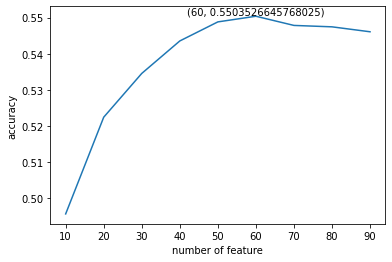

In [36]:
max_index=np.argmax(scores)
plt.plot(feature_scale,scores)
plt.text(feature_scale[max_index],scores[max_index],(feature_scale[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of feature')
plt.ylabel('accuracy')
plt.show()

In [22]:
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn import model_selection

feature_scale = np.arange(55,65,1)
x_shape=[]
scores = []
for i in tqdm(feature_scale):
    x_copy = MyPCA(data_vec,int(i))

    x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)

    classifier = SVC(kernel='linear')

    history = classifier.fit(x_train,y_train)

    score = classifier.score(x_test,y_test)

    x_shape.append(x_copy.shape[1])

    scores.append(score)

100%|██████████| 10/10 [21:20<00:00, 128.01s/it]


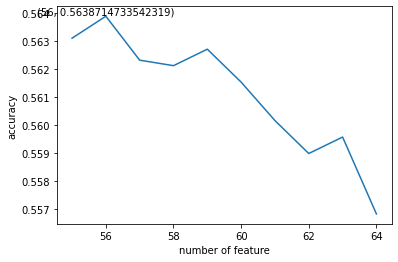

In [23]:
max_index=np.argmax(scores)
plt.plot(feature_scale,scores)
plt.text(feature_scale[max_index],scores[max_index],(feature_scale[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of feature')
plt.ylabel('accuracy')
plt.show()

In [24]:
print(feature_scale,scores)

[55 56 57 58 59 60 61 62 63 64] [0.5630877742946708, 0.5638714733542319, 0.5623040752351097, 0.5621081504702194, 0.5626959247648903, 0.5615203761755486, 0.5601489028213166, 0.5589733542319749, 0.5595611285266457, 0.5568181818181818]


In [39]:
x_copy = MyPCA(data_vec,56)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)

classifier_linear = SVC(kernel='linear')
classifier_poly = SVC(kernel='poly')
classifier_rbf = SVC(kernel='rbf')
classifier_sigmoid = SVC(kernel='sigmoid')

history_linear = classifier_linear.fit(x_train,y_train)
history_poly = classifier_poly.fit(x_train,y_train)
history_rbf = classifier_rbf.fit(x_train,y_train)
history_sigmoid = classifier_sigmoid.fit(x_train,y_train)

score_linear = classifier_linear.score(x_test,y_test)
score_poly = classifier_poly.score(x_test,y_test)
score_rbf = classifier_rbf.score(x_test,y_test)
score_sigmoid = classifier_sigmoid.score(x_test,y_test)

print("linear:",score_linear)
print("poly:",score_poly)
print("rbf:",score_rbf)
print("sigmod:",score_sigmoid)

linear: 0.5511363636363636
poly: 0.44612068965517243
rbf: 0.5403605015673981
sigmod: 0.23197492163009403


In [27]:
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn import model_selection

feature_scale = np.arange(10,100,10)
x_shape=[]
scores = []
scores_train=[]
for i in tqdm(feature_scale):
    x_copy = MyPCA(data_vec,int(i))

    x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)

    classifier = SVC(kernel='rbf')

    history = classifier.fit(x_train,y_train)

    score_train = classifier.score(x_train,y_train)

    score = classifier.score(x_test,y_test)

    x_shape.append(x_copy.shape[1])

    scores.append(score)
    scores_train.append(score_train)

100%|██████████| 9/9 [04:40<00:00, 31.18s/it]


In [29]:
print(feature_scale,scores)

[10 20 30 40 50 60 70 80 90] [0.5182210031347962, 0.5427115987460815, 0.5605407523510971, 0.5628918495297806, 0.5662225705329154, 0.5715125391849529, 0.5713166144200627, 0.5685736677115988, 0.5689655172413793]


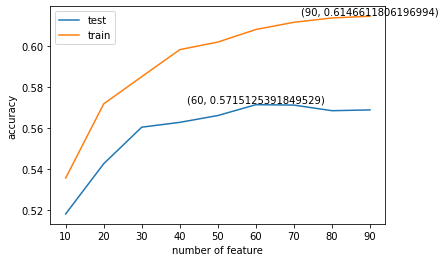

In [30]:
max_index=np.argmax(scores)
max_index_train=np.argmax(scores_train)
plt.plot(feature_scale,scores,label='test')
plt.plot(feature_scale,scores_train,label='train')
plt.text(feature_scale[max_index],scores[max_index],(feature_scale[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.text(feature_scale[max_index_train],scores_train[max_index_train],(feature_scale[max_index_train],scores_train[max_index_train]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of feature')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [67]:
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn import model_selection

feature_scale = np.arange(55,65,1)
x_shape=[]
scores = []
for i in tqdm(feature_scale):
    x_copy = MyPCA(data_vec,int(i))

    x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)

    classifier = SVC(kernel='rbf')

    history = classifier.fit(x_train,y_train)

    score = classifier.score(x_test,y_test)

    x_shape.append(x_copy.shape[1])

    scores.append(score)

100%|██████████| 10/10 [02:33<00:00, 15.33s/it]


In [68]:
print(feature_scale,scores)

[55 56 57 58 59 60 61 62 63 64] [0.5679858934169278, 0.5679858934169278, 0.5685736677115988, 0.5689655172413793, 0.5699451410658307, 0.5715125391849529, 0.5707288401253918, 0.5697492163009404, 0.5721003134796239, 0.5697492163009404]


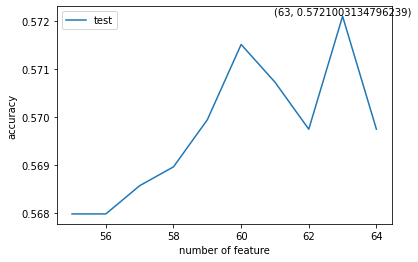

In [69]:
max_index=np.argmax(scores)
plt.plot(feature_scale,scores,label='test')
plt.text(feature_scale[max_index],scores[max_index],(feature_scale[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of feature')
plt.ylabel('accuracy')
plt.legend()
plt.show()

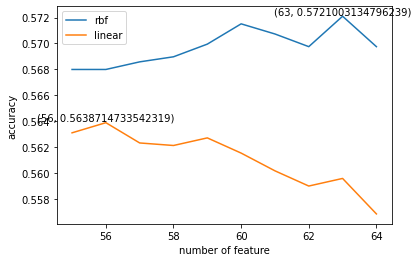

In [83]:
X=[55,56,57,58,59,60,61,62,63,64]
rbf_Y=[0.5679858934169278, 0.5679858934169278, 0.5685736677115988, 0.5689655172413793, 0.5699451410658307, 0.5715125391849529, 0.5707288401253918, 0.5697492163009404, 0.5721003134796239, 0.5697492163009404]
linear_Y=[0.5630877742946708, 0.5638714733542319, 0.5623040752351097, 0.5621081504702194, 0.5626959247648903, 0.5615203761755486, 0.5601489028213166, 0.5589733542319749, 0.5595611285266457, 0.5568181818181818]
max_rbf=np.argmax(rbf_Y)
max_linear=np.argmax(linear_Y)
plt.plot(X,rbf_Y,label='rbf')
plt.plot(X,linear_Y,label='linear')
plt.text(X[max_rbf],rbf_Y[max_rbf],(X[max_rbf],rbf_Y[max_rbf]),ha='center', va='bottom', fontsize=10)
plt.text(X[max_linear],linear_Y[max_linear],(X[max_linear],linear_Y[max_linear]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of feature')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("lin~rbf.png")
plt.show()

In [70]:
C_scale = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
scores = []
x_copy = MyPCA(data_vec,int(63))
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)
for i in tqdm(C_scale):

    classifier = SVC(C=i,kernel='rbf')

    history = classifier.fit(x_train,y_train)

    score = classifier.score(x_test,y_test)

    scores.append(score)


100%|██████████| 12/12 [03:28<00:00, 17.41s/it]


In [71]:
print(C_scale,scores)

[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] [0.25587774294670845, 0.3802899686520376, 0.49823667711598746, 0.5338949843260188, 0.5478056426332288, 0.5581896551724138, 0.5611285266457681, 0.5638714733542319, 0.5672021943573667, 0.5685736677115988, 0.5707288401253918, 0.5721003134796239]


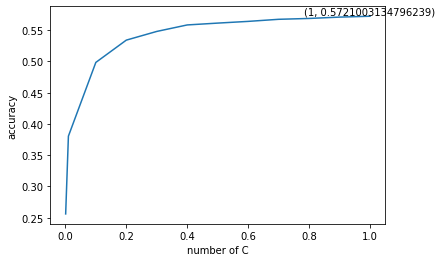

In [72]:
max_index=np.argmax(scores)
plt.plot(C_scale,scores)
plt.text(C_scale[max_index],scores[max_index],(C_scale[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of C')
plt.ylabel('accuracy')
plt.show()

In [73]:
x_copy = MyPCA(data_vec,63)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)

classifier_auto = SVC(C=1,kernel='rbf',gamma='auto')
classifier_scale = SVC(C=1,kernel='rbf',gamma='scale')


history_auto = classifier_auto.fit(x_train,y_train)
history_scale = classifier_scale.fit(x_train,y_train)


score_auto = classifier_auto.score(x_test,y_test)
score_scale = classifier_scale.score(x_test,y_test)

print("auto:",score_auto)
print("scale:",score_scale)

auto: 0.4947100313479624
scale: 0.5721003134796239


In [85]:
gamma = [0.001,0.01,0.5,1,5]
scores_train = []
scores_test = []
x_copy = MyPCA(data_vec,int(63))
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)
for i in tqdm(gamma):

    classifier = SVC(C=i,kernel='rbf',gamma=i)

    history = classifier.fit(x_train,y_train)

    score_train = classifier.score(x_train,y_train)
    score_test = classifier.score(x_test,y_test)

    scores_train.append(score_train)
    scores_test.append(score_test)


100%|██████████| 5/5 [06:40<00:00, 80.07s/it]


In [88]:
print(scores_train)
print(scores_test)

[0.26559744730875806, 0.22529179612058106, 0.35275841800319085, 0.9992442690402217, 0.9992442690402217]
[0.25999216300940436, 0.21845611285266459, 0.18025078369905956, 0.18083855799373041, 0.18025078369905956]


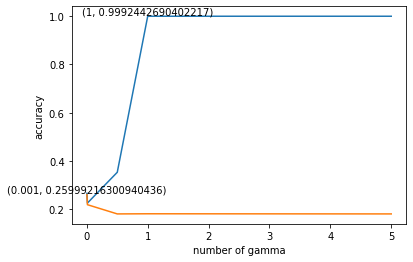

In [87]:
max_index=np.argmax(scores_train)
max_index_test=np.argmax(scores_test)
plt.plot(gamma,scores_train)
plt.plot(gamma,scores_test)
plt.text(gamma[max_index],scores_train[max_index],(gamma[max_index],scores_train[max_index]),ha='center', va='bottom', fontsize=10)
plt.text(gamma[max_index_test],scores_test[max_index_test],(gamma[max_index_test],scores_test[max_index_test]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of gamma')
plt.ylabel('accuracy')
plt.savefig("gamma.png")
plt.show()

random forest

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

n_estimators

In [39]:
print(labels.shape)

(17013,)


In [96]:
scores = []
x_copy=MyPCA(data_vec,63)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_copy,labels,
                                                    test_size=0.3,random_state=1)
n_est = np.arange(1,201,10)
for i in tqdm(n_est):
    rfc = RandomForestClassifier(n_estimators=i)
    history = rfc.fit(x_train,y_train)
    score = rfc.score(x_test,y_test)
    # score = cross_val_score(rfc, x_train, y_train, cv=10).mean()
    scores.append(score)


100%|██████████| 20/20 [08:35<00:00, 25.77s/it]


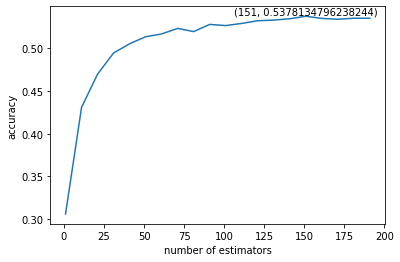

In [90]:
max_index=np.argmax(scores)
plt.plot(n_est,scores)
plt.text(n_est[max_index],scores[max_index],(n_est[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.savefig("extimate.png")
plt.show()

In [91]:
n_est = np.arange(n_est[max_index]-5,n_est[max_index]+5,1)
scores=[]
for i in tqdm(n_est):
    rfc = RandomForestClassifier(n_estimators=i)
    history = rfc.fit(x_train,y_train)
    score = rfc.score(x_test,y_test)
    scores.append(score)

100%|██████████| 10/10 [02:31<00:00, 15.19s/it]


In [94]:
print(n_est,scores)

[146 147 148 149 150 151 152 153 154 155] [0.5358542319749217, 0.5378134796238244, 0.5372257053291536, 0.5335031347962382, 0.539576802507837, 0.5403605015673981, 0.5299764890282131, 0.5317398119122257, 0.524294670846395, 0.5336990595611285]


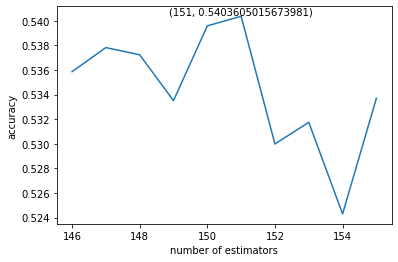

In [95]:
max_index=np.argmax(scores)
plt.plot(n_est,scores)
plt.text(n_est[max_index],scores[max_index],(n_est[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.savefig("extimate_151.png")
plt.show()

max_depth

In [52]:
scores = []

max_depth = np.arange(10,30,1)
for i in tqdm(max_depth):
    rfc = RandomForestClassifier(n_estimators=173,max_depth=i)
    history = rfc.fit(x_train,y_train)
    score = rfc.score(x_test,y_test)
    scores.append(score)

100%|██████████| 20/20 [04:26<00:00, 13.30s/it]


In [53]:
print(max_depth,scores)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [0.5321316614420063, 0.5311520376175548, 0.5278213166144201, 0.5338949843260188, 0.5446708463949843, 0.5358542319749217, 0.5356583072100314, 0.5288009404388715, 0.5344827586206896, 0.5313479623824452, 0.542319749216301, 0.531935736677116, 0.5364420062695925, 0.5384012539184952, 0.5301724137931034, 0.5325235109717869, 0.5446708463949843, 0.5354623824451411, 0.538205329153605, 0.5346786833855799]


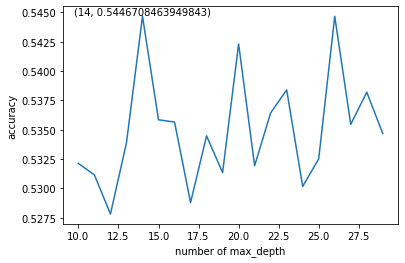

In [54]:
max_index=np.argmax(scores)
plt.plot(max_depth,scores)
plt.text(max_depth[max_index],scores[max_index],(max_depth[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of max_depth')
plt.ylabel('accuracy')
plt.show()

max_feature

In [55]:
scores = []

max_feature = np.arange(20,41,1)
for i in tqdm(max_feature):
    rfc = RandomForestClassifier(n_estimators=173,max_depth=max_depth[max_index],max_features=i)
    history = rfc.fit(x_train,y_train)
    score = rfc.score(x_test,y_test)
    scores.append(score)

rfc_auto=RandomForestClassifier(n_estimators=173,max_depth=max_depth[max_index],max_features='auto')
rfc_log2=RandomForestClassifier(n_estimators=173,max_depth=max_depth[max_index],max_features='log2')
rfc_sqrt=RandomForestClassifier(n_estimators=173,max_depth=max_depth[max_index],max_features='sqrt')

history_auto = rfc_auto.fit(x_train,y_train)
history_log2 = rfc_log2.fit(x_train,y_train)
history_sqrt = rfc_sqrt.fit(x_train,y_train)

print('auto:',rfc_auto.score(x_test,y_test))
print('log2:',rfc_log2.score(x_test,y_test))
print('sqrt:',rfc_sqrt.score(x_test,y_test))

100%|██████████| 21/21 [15:09<00:00, 43.30s/it]


auto: 0.5317398119122257
log2: 0.5360501567398119
sqrt: 0.5350705329153606


In [56]:
print(max_feature,scores)

[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] [0.5384012539184952, 0.5286050156739812, 0.5352664576802508, 0.5362460815047022, 0.5288009404388715, 0.5421238244514106, 0.5303683385579937, 0.5295846394984326, 0.5311520376175548, 0.5260579937304075, 0.522923197492163, 0.5293887147335423, 0.5280172413793104, 0.5278213166144201, 0.5317398119122257, 0.5307601880877743, 0.5297805642633229, 0.5325235109717869, 0.5293887147335423, 0.5274294670846394, 0.5288009404388715]


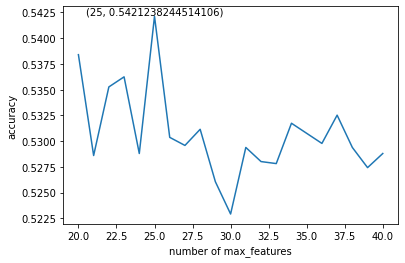

In [57]:
max_index=np.argmax(scores)
plt.plot(max_feature,scores)
plt.text(max_feature[max_index],scores[max_index],(max_feature[max_index],scores[max_index]),ha='center', va='bottom', fontsize=10)
plt.xlabel('number of max_features')
plt.ylabel('accuracy')
plt.show()

AdaBoosting

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import *
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# warnings.filterwarnings('ignore')
# depth = np.linspace(20,50,31)
depth = np.arange(20,200,10)
mae=[]
mse=[]
accuracy=[]
for i in tqdm(depth):
    clf=DecisionTreeClassifier(max_depth=i,min_samples_split=20,min_samples_leaf=5)
    AdaBoostClf=AdaBoostClassifier(clf)
    AdaBoostClf.fit(x_train,y_train)
    prediction1=AdaBoostClf.predict(x_test)
    mae.append(mean_absolute_error(y_test,prediction1))
    mse.append(mean_squared_error(y_test,prediction1))
    accuracy.append(accuracy_score(y_test,prediction1))

100%|██████████| 18/18 [15:08<00:00, 50.47s/it]


In [59]:
print(depth, mae)
print(depth, mse)

[ 20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190] [1.0385971786833856, 1.0266457680250785, 1.0233150470219436, 1.0045062695924765, 1.0501567398119123, 1.0213557993730407, 1.0070532915360502, 1.0154780564263324, 1.025078369905956, 1.0121473354231976, 1.0276253918495297, 1.025666144200627, 1.0325235109717867, 1.0356583072100314, 1.0219435736677116, 1.006269592476489, 0.9925548589341693, 1.0427115987460815]
[ 20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190] [2.730603448275862, 2.6955329153605017, 2.70826802507837, 2.6189263322884013, 2.8197492163009406, 2.707876175548589, 2.677115987460815, 2.6408699059561127, 2.6931818181818183, 2.674373040752351, 2.721590909090909, 2.7004310344827585, 2.740203761755486, 2.7010188087774294, 2.6849529780564265, 2.635579937304075, 2.554858934169279, 2.7782131661442007]


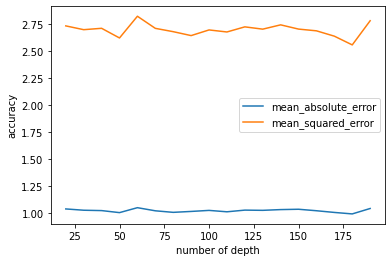

In [60]:
plt.plot(depth, mae, label='mean_absolute_error')
plt.plot(depth, mse, label='mean_squared_error')
plt.xlabel('number of depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [61]:
print(depth, accuracy)

[ 20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190] [0.4659090909090909, 0.47355015673981193, 0.4753134796238245, 0.4782523510971787, 0.46747648902821315, 0.47335423197492166, 0.4855015673981191, 0.46943573667711597, 0.47100313479623823, 0.47844827586206895, 0.47511755485893414, 0.47198275862068967, 0.4725705329153605, 0.46532131661442006, 0.47002351097178685, 0.47981974921630094, 0.4782523510971787, 0.4715909090909091]


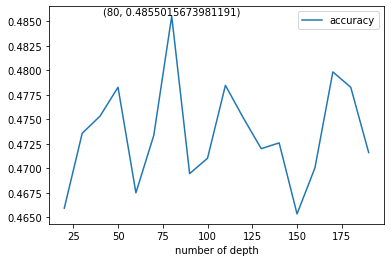

In [62]:
max_index = np.argmax(accuracy)
plt.plot(depth, accuracy, label='accuracy')
plt.xlabel('number of depth')
plt.text(depth[max_index], accuracy[max_index], (depth[max_index], accuracy[max_index]), ha='center', va='bottom',
         fontsize=10)
plt.legend()
plt.show()

In [63]:
depth = np.arange(depth[max_index]-5,depth[max_index]+5,1)
mae=[]
mse=[]
accuracy=[]
for i in tqdm(depth):
    clf=DecisionTreeClassifier(max_depth=i,min_samples_split=20,min_samples_leaf=5)
    AdaBoostClf=AdaBoostClassifier(clf)
    AdaBoostClf.fit(x_train,y_train)
    prediction1=AdaBoostClf.predict(x_test)
    mae.append(mean_absolute_error(y_test,prediction1))
    mse.append(mean_squared_error(y_test,prediction1))
    accuracy.append(accuracy_score(y_test,prediction1))

100%|██████████| 10/10 [07:44<00:00, 46.44s/it]


In [75]:
print(depth, mae)
print(depth, mse)

[75 76 77 78 79 80 81 82 83 84] [1.0188087774294672, 1.0438871473354232, 1.0070532915360502, 1.0282131661442007, 1.0237068965517242, 1.029192789968652, 1.026253918495298, 1.0284090909090908, 1.0372257053291536, 1.0244905956112853]
[75 76 77 78 79 80 81 82 83 84] [2.6434169278996866, 2.769592476489028, 2.6391065830721003, 2.7233542319749215, 2.737656739811912, 2.6969043887147337, 2.7331504702194356, 2.707484326018809, 2.741771159874608, 2.6949451410658307]


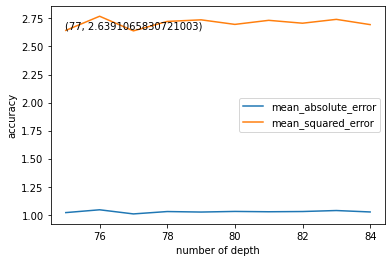

In [80]:
min_index = np.argmin(mse)
plt.plot(depth, mae, label='mean_absolute_error')
plt.plot(depth, mse, label='mean_squared_error')
plt.text(depth[min_index], mse[min_index], (depth[min_index], mse[min_index]), ha='center', va='bottom',
         fontsize=10)
plt.xlabel('number of depth')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("mse_mae.png")
plt.show()


In [81]:
print(depth, accuracy)

[75 76 77 78 79 80 81 82 83 84] [0.4704153605015674, 0.46551724137931033, 0.4827586206896552, 0.4727664576802508, 0.4800156739811912, 0.4692398119122257, 0.47492163009404387, 0.4713949843260188, 0.4692398119122257, 0.47198275862068967]


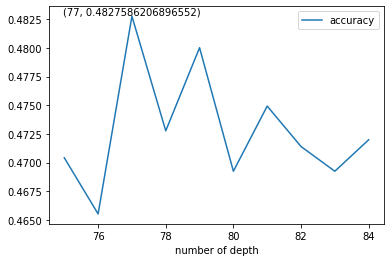

In [82]:
max_index = np.argmax(accuracy)
plt.plot(depth, accuracy, label='accuracy')
plt.xlabel('number of depth')
plt.text(depth[max_index], accuracy[max_index], (depth[max_index], accuracy[max_index]), ha='center', va='bottom',
         fontsize=10)
plt.legend()
plt.savefig("ada_accu.png")
plt.show()

KNN

In [104]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import glob
from sklearn.neighbors import KNeighborsClassifier
accuracymax = 0
kmax = 0
accuracy_list=[]
for k in range(1,100):

    print("k = %d"%k)
    # clf = KNeighborsClassifier(n_neighbors=11).fit(XX_train, y_train)
    clf = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    predictions_labels = clf.predict(x_test)

    print(predictions_labels)

    print((classification_report(y_test, predictions_labels)))

    accuracy = accuracy_score(y_test, predictions_labels)
    print("accuracy = %lf" % accuracy)

    if accuracy > accuracymax:
        accuracymax = accuracy
        kmax = k
        print("update: k = %d, accuracy = %lf" % (kmax,accuracymax))
    accuracy_list.append(accuracy)
print("max: k = %d, accuracy = %lf"%(kmax,accuracymax))

k = 1
[1 1 1 ... 1 0 4]
              precision    recall  f1-score   support

           0       0.35      0.38      0.36       871
           1       0.40      0.28      0.33       807
           2       0.53      0.64      0.58       784
           3       0.32      0.31      0.31       867
           4       0.37      0.43      0.40       921
           5       0.40      0.35      0.37       854

    accuracy                           0.40      5104
   macro avg       0.40      0.40      0.39      5104
weighted avg       0.39      0.40      0.39      5104

accuracy = 0.396160
update: k = 1, accuracy = 0.396160
k = 2
[1 1 1 ... 1 0 4]
              precision    recall  f1-score   support

           0       0.32      0.56      0.41       871
           1       0.34      0.29      0.31       807
           2       0.54      0.59      0.57       784
           3       0.34      0.38      0.36       867
           4       0.41      0.34      0.37       921
           5       0.62      

In [105]:
print(accuracy_list)

[0.3961598746081505, 0.39322100313479624, 0.4231974921630094, 0.443769592476489, 0.4476880877742947, 0.45141065830721006, 0.4549373040752351, 0.45787617554858934, 0.4649294670846395, 0.4663009404388715, 0.4731583072100313, 0.4760971786833856, 0.47433385579937304, 0.48295454545454547, 0.48040752351097177, 0.48099529780564265, 0.4837382445141066, 0.4825626959247649, 0.4837382445141066, 0.47766457680250785, 0.48197492163009403, 0.48197492163009403, 0.4782523510971787, 0.4802115987460815, 0.4827586206896552, 0.4766849529780564, 0.47981974921630094, 0.48197492163009403, 0.4823667711598746, 0.48315047021943575, 0.48608934169278994, 0.4825626959247649, 0.4802115987460815, 0.4802115987460815, 0.47981974921630094, 0.4782523510971787, 0.475705329153605, 0.475705329153605, 0.4788401253918495, 0.4782523510971787, 0.4766849529780564, 0.4759012539184953, 0.47511755485893414, 0.4759012539184953, 0.4753134796238245, 0.4745297805642633, 0.4759012539184953, 0.4739420062695925, 0.4725705329153605, 0.4684

END: OWN CODE